#**Interacción de partículas**

Interación de particulas, una partícula es el fragmento más pequeño de materia que mantiene las propiedades químicas de un cuerpo. En esta simulación se busca imitar un poco como es la interación entre ellas, como es que se desplazan, se agrandan, se minimizan o desaparecen debido a su interacción constante.

##Reglas

Al iniciar la simulación se nos dan ciertas particulas en color amarillo que son las que se encuentran en el ambiente o en el espacio, por lo que se generan las siguientes reglas:

1.- Si una celda no cuenta con una particula pero esta tiene vecinos, los vecinos incrementan su volumen para llenar esa celda, solo si cuenta con más de un vecino pero menos de 3, por la expansión de las particulas.

2.-Si una celda que forma parte de una particula, cuenta con más de tres vecinos, esta muere o deja de formar parte de la particula, por el exceso de volumen, lo que genera que la particula disminuya su tamaño.

3.-Cualquier celda que cuente con más de dos vecinos se une a la particula, por el aumento de tamaño de la particula.

Estos patrones crean las interacciones de una particula, ya que entre ellas comparten espacio, pero cuando despues de cierto tiempo pierden masa y volumen lo que hace que disminuya su tamaño, por lo que da chance que otra particula tome su espacio y se expanda.

## Implementación

In [ ]:
!python3 -m pip install mesa

In [ ]:
from mesa import Agent, Model
from mesa.space import SingleGrid
from mesa.time import SimultaneousActivation
from mesa.datacollection import DataCollector
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mlp
import matplotlib.animation as animation
plt.rcParams["animation.html"] = "jshtml"
mlp.rcParams['animation.embed_limit'] = 2**128
import numpy as np
import pandas as pd
import time
import datetime
import random

In [ ]:
class GameLifeAgent(Agent):

    def __init__(self, unique_id, model):

        super().__init__(unique_id, model)
        self.live = np.random.choice([0,1])
        self.next_state = None

    def step(self):

        neighbours = self.model.grid.get_neighbors(
            self.pos,
            moore=False,
            include_center=False)

        live_neighbours = 0
        for neighbor in neighbours:
            live_neighbours = live_neighbours + neighbor.live

        self.next_state = self.live
        if self.next_state == 0 and (live_neighbours > 1 and live_neighbours < 3):
            self.next_state = 1
        elif self.next_state == 1 and live_neighbours > 3:
          self.next_state = 0
        else:
            if live_neighbours > 2:
                self.next_state = 1

    def advance(self):

        self.live = self.next_state

class GameLifeModel(Model):

    def __init__(self, width, height):
        self.width = width
        self.height = height

        self.reset()

    def reset(self):
        self.num_agents = self.width * self.height
        self.grid = SingleGrid(self.width, self.height, True)
        self.schedule = SimultaneousActivation(self)

        for (content, pos) in self.grid.coord_iter():

            a = GameLifeAgent(pos, self)
            self.grid.place_agent(a, pos)
            self.schedule.add(a)

        self.datacollector = DataCollector(
            model_reporters={"Grid": self.get_grid,
                             "Live": self.get_live}
        )

    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()

    def get_grid(self):

        grid = np.zeros((self.grid.width, self.grid.height))

        for cell in self.grid.coord_iter():
            cell_content, pos = cell
            x, y = pos
            grid[x][y] = cell_content.live

        return grid

    def get_live(self):
        total_live_agents = 0

        for cell in model.grid.coord_iter():
            agent, _ = cell
            if isinstance(agent, GameLifeAgent):
                total_live_agents += agent.live

        return total_live_agents

In [ ]:
GRID_SIZE = 100
NUM_GENERATIONS = 100

start_time = time.time()

model = GameLifeModel(GRID_SIZE, GRID_SIZE)
for i in range(NUM_GENERATIONS):
    model.step()
final_time = time.time()

print('Tiempo de ejecución:', str(datetime.timedelta(seconds=(final_time - start_time))))

Tiempo de ejecución: 0:00:04.421712


In [ ]:
all_grids = model.datacollector.get_model_vars_dataframe()

In [ ]:
all_grids

,Grid,Live
0,"[[1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0,...",5071
1,"[[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0,...",8134
2,"[[1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0,...",5354
3,"[[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0,...",6356
4,"[[1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0,...",6990
...,...,...
95,"[[0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0,...",6764
96,"[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...",6690
97,"[[0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0,...",6870
98,"[[0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0,...",6838


In [ ]:
%%capture

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(7,7))

axs.set_xticks([])
axs.set_yticks([])


colors = []
colors.append(np.array([255 / 255, 255 / 255, 0, 1]))
colors.append(np.array([0, 0, 0, 1]))
colormap = mlp.colors.ListedColormap(colors)

patch_grid = axs.imshow(all_grids['Grid'].iloc[0], cmap=colormap, vmin=0, vmax=1)

cells_alive = []
def animate(i):
    patch_grid.set_data(all_grids['Grid'].iloc[i])

    cells_alive.append(all_grids['Live'].iloc[i])

anim = animation.FuncAnimation(fig, animate, frames=NUM_GENERATIONS)

In [ ]:
anim

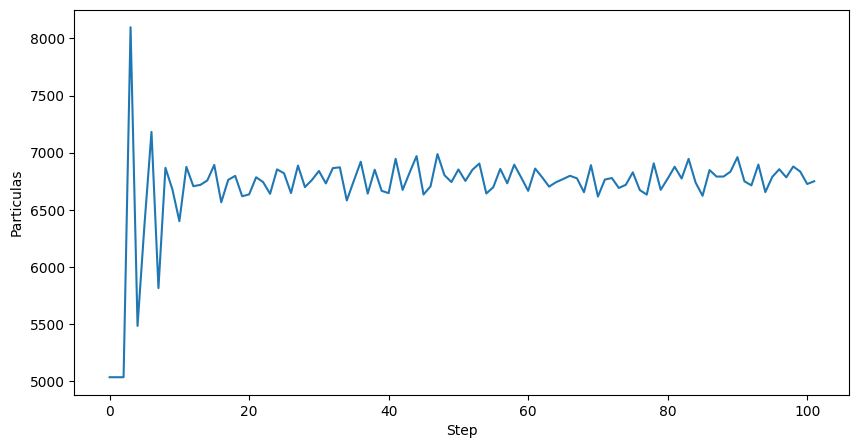

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(10,5))

axs.set_xlabel("Step")
axs.set_ylabel("Particulas")

plt.plot(cells_alive)
plt.show()

In [ ]:
NUM_REPS = 100
GRID_SIZE = 10
NUM_GENERATIONS = 1000

model = GameLifeModel(GRID_SIZE, GRID_SIZE)

batch_data = dict(time=[], alive=[])
for _ in range(NUM_REPS):
    start_time = time.time()

    model.reset()
    for i in range(NUM_GENERATIONS):
        model.step()
    final_time = time.time()

    all_grids = model.datacollector.get_model_vars_dataframe()

    batch_data['time'].append(final_time - start_time)
    batch_data['alive'].append(all_grids['Live'].to_numpy())


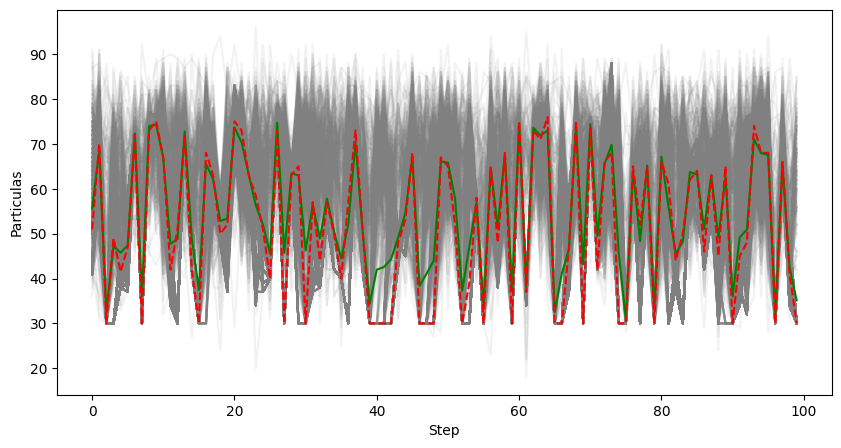

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(10,5))

axs.set_xlabel("Step")
axs.set_ylabel("Particulas")

#axs.set_prop_cycle('color', list(plt.cm.(np.linspace(0, 1, NUM_REPS))))
plt.plot(batch_data['alive'], color='Grey', alpha=0.1)

plt.plot(np.average(np.array(batch_data['alive']), axis=1), color='Green')
plt.plot(np.median(np.array(batch_data['alive']), axis=1), color='Red', linestyle='dashed')

plt.show()